In [268]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

### Binomial proportion

In [269]:
n = 146
y = 57
phat = y / n
se = np.sqrt(phat * (1 - phat) / n)
print(f"phat = {phat:.2f}, se = {se:.2f}")

phat = 0.39, se = 0.04


### Central Limit Theorem (CLT)

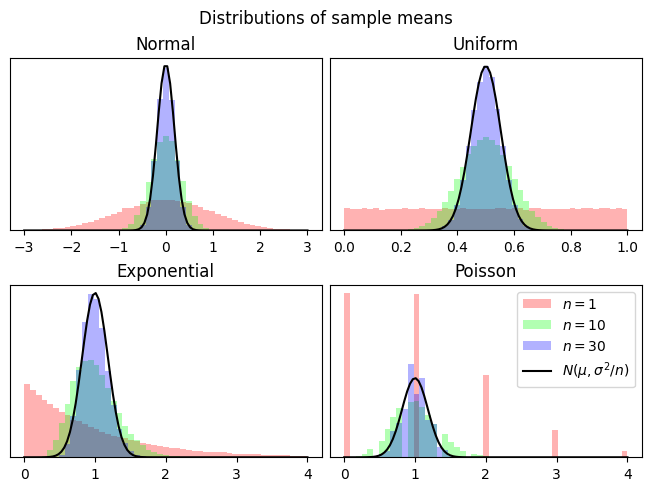

In [270]:
m = 100_000
fig, axes = plt.subplots(nrows=2, ncols=2, layout="constrained")
axes = axes.ravel()
plt.suptitle("Distributions of sample means")

ns = [1, 10, 30]
ds = [stats.norm(), stats.uniform(), stats.expon(), stats.poisson(1)]
cs = [(1, 0, 0, 0.3), (0, 1, 0, 0.3), (0, 0, 1, 0.3)]
lows = [-3, 0, 0, 0]
highs = [3, 1, 4, 4]
titles = ["Normal", "Uniform", "Exponential", "Poisson"]

for ax, d, low, high, title in zip(axes, ds, lows, highs, titles):
    bins = np.linspace(low, high, 50)
    for n, c in zip(ns, cs):
        x = d.rvs(size=(m, n))
        xbar = x.mean(axis=1)
        ax.hist(xbar, bins=bins, label=f"$n={n}$", color=c, density=True)
        ax.set_yticks([])
        ax.set_title(title)
    xbars = np.linspace(low, high, 100)
    norm = stats.norm(d.mean(), d.std() / np.sqrt(n))
    ax.plot(xbars, norm.pdf(xbars), "k", label="$N(\\mu, \\sigma^2/n)$")


axes[-1].legend()
plt.show()

### Confidence intervals for the mean

In [271]:
n = 146
y = 57
phat = y / n
se = np.sqrt(phat * (1 - phat) / n)
z95 = stats.norm().ppf(1 - 0.05 / 2)
print(f"95%-inverval = [{phat:.2f} ± {z95*se:.2f}]")

95%-inverval = [0.39 ± 0.08]


### Combining means and proportions

In [272]:
phat = 0.57
m = 400
qhat = 0.45
n = 600
sephat = np.sqrt(phat * (1 - phat) / m)
seqhat = np.sqrt(qhat * (1 - qhat) / n)
gap = phat - qhat
segap = np.sqrt(sephat**2 + seqhat**2)
z999 = stats.norm().ppf(1 - 0.001 / 2)
print(
    f"""\
phat = {phat:.2f}, sephat = {sephat:.2f}, 
qhat = {qhat:.2f}, seqhat = {seqhat:.2f}
gap = {gap:.2f}, segap = {segap:.2f}, 99.9%-CI = [{gap:.2f} ± {z999*segap:.2f}]
"""
)

phat = 0.57, sephat = 0.02, 
qhat = 0.45, seqhat = 0.02
gap = 0.12, segap = 0.03, 99.9%-CI = [0.12 ± 0.11]



ybar = 60.40
T = 3.70
pvalue = 0.07


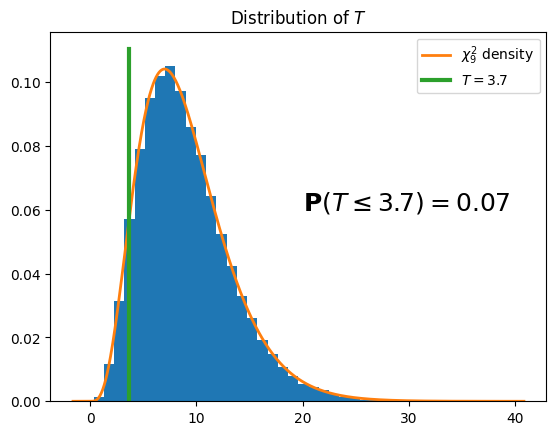

In [273]:
m = 10
n = 100
y = np.array([61, 64, 54, 61, 59, 58, 65, 62, 61, 59])
ybar = y.mean()
T = (1 / ybar + 1 / (n - ybar)) * np.sum((y - ybar) ** 2)
print(f"ybar = {ybar:.2f}\nT = {T:.2f}")

r = 100_000
ys = stats.binom(n, 0.8).rvs(size=(r, m))
ybars = ys.mean(axis=1, keepdims=True)
Ts = (1 / (n - ybars) + 1 / ybars) * (np.sum((ys - ybars) ** 2, axis=1, keepdims=True))
pvalue = np.mean(Ts <= T)
print(f"pvalue = {pvalue:.2f}")

plt.hist(Ts, bins=40, density=True)
u = np.linspace(*plt.xlim(), 1000)
plt.plot(u, stats.chi2(m - 1).pdf(u), lw=2, label=f"$\\chi^2_{m - 1}$ density")  # type: ignore
plt.plot([T, T], plt.ylim(), lw=3, label=f"$T = {T:.1f}$")
plt.title("Distribution of $T$")
plt.text(
    20,
    0.06,
    f"$\\mathbf{{P}}(T \\leq {T:.1f}) = {stats.chi2(m - 1).cdf(T):.2f}$",
    fontsize=18,
)
plt.legend()
plt.show()

### Sometimes your model isn't built-in

**Example:** Simulate the distribution of the number of girls born in $n$ births assuming:

- In single births, the baby is a girl 48.8% of the time.
- Fraternal twins occur once in 125 birth, and each has a 49.5% chance of being a girl.
- Identical twins occur once in 300 births, and each has a 49.5% chance of being a girl.
- Triplets, quadruplets, etc. occur too rarely to take into account.


In [274]:
psingle = 1 - 1 / 125 - 1 / 300
pfraternal = 1 / 125
pidentical = 1 / 300

psinglegirl = 0.488
ptwingirl = 0.495

p0 = (
    psingle * psinglegirl
    + pfraternal * (1 - ptwingirl) ** 2
    + pidentical * (1 - ptwingirl)
)
p1 = psingle * (1 - psinglegirl) + 2 * pfraternal * ptwingirl * (1 - ptwingirl)
p2 = pfraternal * ptwingirl**2 + pidentical * ptwingirl

assert p0 + p1 + p2 == 1


def sample_girls(m, n):
    x = stats.multinomial(n, [p0, p1, p2]).rvs(m)
    return x @ np.array([0, 1, 2])

**Example: A mixture model**

Write a function to sample heights of American adults, given:

- $52\%$ women, $48\%$ men

- Heights of men (inches): $N(\mu = 69.1, \sigma = 2.9)$

- Heights of women (inches): $N(\mu = 63.7, \sigma = 2.7)$

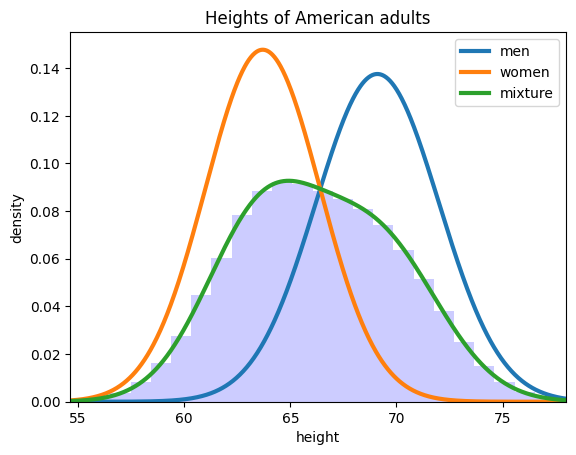

In [275]:
is_woman_d = stats.bernoulli(0.52)
man_height_d = stats.norm(69.1, 2.9)
woman_height_d = stats.norm(63.7, 2.7)


def sample_height(n):
    is_woman = is_woman_d.rvs(n)
    man_height = man_height_d.rvs(n)
    woman_height = woman_height_d.rvs(n)
    height = np.where(is_woman, woman_height, man_height)
    return height


h = sample_height(100_000)
plt.hist(h, bins=30, density=True, color=(0, 0, 1, 0.2))
plt.xlim(h.mean() - 3 * h.std(), h.mean() + 3 * h.std())
u = np.linspace(*plt.xlim(), 1000)
plt.plot(u, man_height_d.pdf(u), lw=3, label="men")
plt.plot(u, woman_height_d.pdf(u), lw=3, label="women")
plt.plot(
    u, 0.48 * man_height_d.pdf(u) + 0.52 * woman_height_d.pdf(u), lw=3, label="mixture"
)
plt.title("Heights of American adults")
plt.xlabel("height")
plt.ylabel("density")
plt.legend()
plt.show()

### Bootstrap

In [276]:
df = pd.read_csv("../data/earnings.csv")
df

,height,weight,male,earn,earnk,ethnicity,education,mother_education,father_education,walk,exercise,smokenow,tense,angry,age
0,74,210.0,1,50000.0,50.0,White,16.0,16.0,16.0,3,3,2.0,0.0,0.0,45
1,66,125.0,0,60000.0,60.0,White,16.0,16.0,16.0,6,5,1.0,0.0,0.0,58
2,64,126.0,0,30000.0,30.0,White,16.0,16.0,16.0,8,1,2.0,1.0,1.0,29
3,65,200.0,0,25000.0,25.0,White,17.0,17.0,NaN,8,1,2.0,0.0,0.0,57
4,63,110.0,0,50000.0,50.0,Other,16.0,16.0,16.0,5,6,2.0,0.0,0.0,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1811,61,120.0,0,15000.0,15.0,White,18.0,18.0,18.0,6,1,2.0,0.0,0.0,82
1812,64,130.0,0,8000.0,8.0,White,12.0,12.0,12.0,1,1,1.0,7.0,7.0,33
1813,72,194.0,1,60000.0,60.0,White,12.0,12.0,12.0,2,1,2.0,0.0,0.0,50
1814,63,155.0,0,15000.0,15.0,Other,14.0,14.0,14.0,6,1,2.0,2.0,2.0,69


In [277]:
is_male = df["male"] == 1
male_earnings = df["earn"][is_male]
female_earnings = df["earn"][~is_male]
male_earnings.shape, female_earnings.shape

((675,), (1141,))

In [278]:
female_earnings.median() / male_earnings.median()

np.float64(0.6)

In [279]:
rng = np.random.default_rng()
medians = []
for _ in range(1000):
    x = rng.choice(female_earnings, len(female_earnings))
    y = rng.choice(male_earnings, len(male_earnings))
    medians.append(np.median(x) / np.median(y))

print(f"std(bootstrapped medians) = {np.std(medians):.2f}")

std(bootstrapped medians) = 0.03


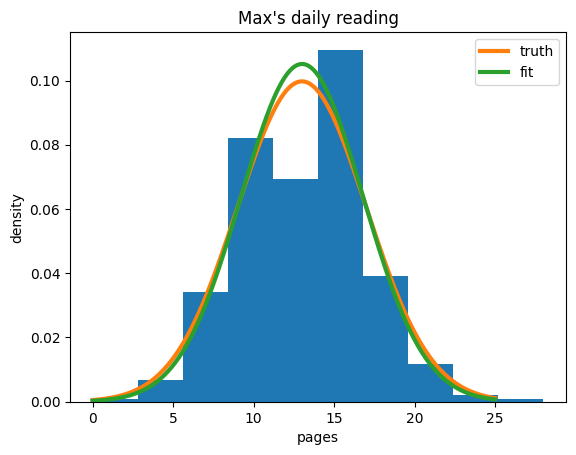

In [280]:
n = 365
mu = 13
sigma = 4
d = stats.norm(mu, sigma)
x = d.rvs(size=n, random_state=42).round().astype(int)
plt.hist(x, density=True)
u = np.linspace(0, 25, 1000)
plt.plot(u, d.pdf(u), lw=3, label="truth")
plt.plot(u, stats.norm(x.mean(), x.std()).pdf(u), lw=3, label="fit")
plt.title("Max's daily reading")
plt.xlabel("pages")
plt.ylabel("density")
plt.legend()

In [281]:
pr_days = np.flatnonzero(x[:-1] > mu + sigma)
nr_days = np.flatnonzero(x[:-1] < mu - sigma)

average_pr_effect = np.mean(x[pr_days + 1] - x[pr_days])
average_nr_effect = np.mean(x[nr_days + 1] - x[nr_days])

print(f"average_pr_effect = {average_pr_effect}")
print(f"average_nr_effect = {average_nr_effect}")

average_pr_effect = -8.078947368421053
average_nr_effect = 6.558139534883721


In [282]:
x[nr_days + 1].mean(), x[pr_days + 1].mean()

(np.float64(13.325581395348838), np.float64(11.763157894736842))

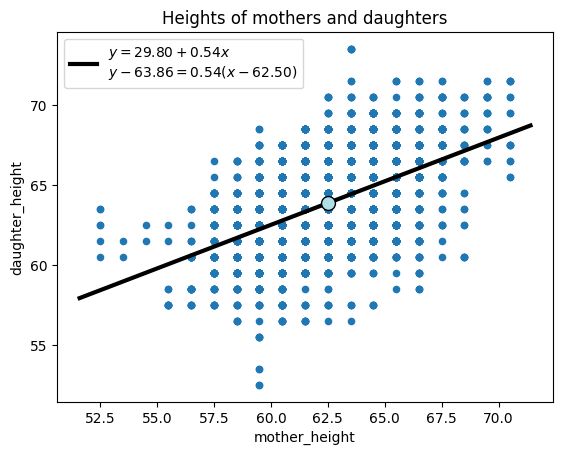

In [283]:
df = pd.read_csv("../data/heights.csv")
df.plot.scatter(
    "mother_height", "daughter_height", title="Heights of mothers and daughters"
)
X = df[["mother_height"]]
x = X["mother_height"]
y = df["daughter_height"]
xbar = x.mean()
ybar = y.mean()
model = LinearRegression()
model.fit(X, y)
b0 = model.intercept_
b1 = model.coef_[0]
xmin, xmax = plt.xlim()
plt.plot(
    [xmin, xmax],
    [b0 + b1 * xmin, b0 + b1 * xmax],
    color="black",
    lw=3,
    label=f"$y = {b0:.2f} + {b1:.2f}x$\n$y - {ybar:.2f} = {b1:.2f}(x - {xbar:.2f})$",
)
plt.plot(
    df["mother_height"].mean(),
    df["daughter_height"].mean(),
    "o",
    color="powderblue",
    mec="black",
    ms=10,
)
plt.legend()
plt.show()